**NECESSARY IMPORTS**

In [1]:
#imports

from tensorflow.python.keras.layers import Dense,Flatten,MaxPooling2D
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
import os
import pandas as pd
import random
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# **Preprocessing**

In [ ]:
#getting the test.csv and converting it to .npy
test = pd.read_csv("/content/drive/MyDrive/URC/Fashion_MNIST/Test/fashion-mnist_test.csv")
testX = test.iloc[:, 1:]
testY = test['label']
np.save("/content/drive/MyDrive/URC/Fashion_MNIST/Test/fashion-mnist_test_X.npy", testX)
np.save("/content/drive/MyDrive/URC/Fashion_MNIST/Test/fashion-mnist_test_Y.npy", testY)

#getting the train.csv and converting it to .npy
train = pd.read_csv("/content/drive/MyDrive/URC/Fashion_MNIST/Train/fashion-mnist_train.csv")
trainX = train.iloc[:40000,1:]
trainY = train.iloc[:40000,0]
np.save("/content/drive/MyDrive/URC/Fashion_MNIST/Train/fashion-mnist_train40k_X.npy", trainX)
np.save("/content/drive/MyDrive/URC/Fashion_MNIST/Train/fashion-mnist_train40k_Y.npy", trainY)

#getting the validation.csv and converting it to .npy
validationX = train.iloc[40000:,1:]
validationY = train.iloc[40000:,0] 
np.save("/content/drive/MyDrive/URC/Fashion_MNIST/Validation/validation20k_X.npy",validationX)
np.save("/content/drive/MyDrive/URC/Fashion_MNIST/Validation/validation20k_Y.npy",validationY)



In [ ]:
validationY.head # checking the data

<bound method NDFrame.head of 40000    0
40001    1
40002    0
40003    0
40004    2
        ..
59995    9
59996    1
59997    8
59998    8
59999    7
Name: label, Length: 20000, dtype: int64>

In [ ]:
#loading the .npy files
%cd /content/drive/MyDrive/URC/Fashion_MNIST/Test
testX = np.load('fashion-mnist_test_X.npy') 
testY = np.load('fashion-mnist_test_Y.npy')

%cd /content/drive/MyDrive/URC/Fashion_MNIST/Validation
validationX = np.load('validation20k_X.npy')
validationY = np.load('validation20k_Y.npy')

%cd /content/drive/MyDrive/URC/Fashion_MNIST/Train
trainX = np.load('fashion-mnist_train40k_X.npy')
trainY = np.load('fashion-mnist_train40k_Y.npy')

**Necessary preprocessing of data** 

---


Necessary Preprocessing for inputting the data into CNN

In [ ]:
def reshape_image (data, size):
  data = np.array(data)
  data = data.reshape(size, 28, 28, 1)
  return data 

In [ ]:
trainX = reshape_image(trainX, trainX.shape[0])
testX = reshape_image(testX, testX.shape[0])
validationX = reshape_image(validationX, validationX.shape[0])

In [ ]:
def preprocessY (lst):
  integer_encoded = label_encoder.fit_transform(np.array(lst))
  trainY = to_categorical(integer_encoded)
  #trainY = to_categorical(lst)
  return trainY

In [ ]:
trainY = preprocessY(trainY)
testY = preprocessY(testY)
validationY = preprocessY(validationY)


# **Model Architecture**

In [ ]:
input_shape = (28,28,1)
batch_size = 128

In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size = (3,3), activation='relu',kernel_initializer='he_uniform' ,input_shape = input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))#if n strides given then strides is taken as pool_size;
#similarly no arg for padding means "valid" padding i.e no artificial manipulation of shape by us
model.add(Conv2D(64,kernel_size=(3,3),activation='relu',kernel_initializer="he_uniform"))
model.add(MaxPooling2D(pool_size=(3,3),strides=2))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss=CategoricalCrossentropy(),
              optimizer = Adam(),
              metrics=['accuracy'])
#tf.keras.optimizers.Nadam(
 #   learning_rate=0.00001, beta_1=0.99, beta_2=0.999, epsilon=1e-07, name="Nadam",
#)

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               409856    
_________________________________________________________________
dense_15 (Dense)             (None, 10)               

# **Generator Function**

In [ ]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,height_shift_range=0.08, zoom_range=0.08) #to make our training data more diverse, we introduce augmentation

# **Checkpoint Basics**

In [ ]:
checkpoint_path = '/content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/CNN/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True,verbose = 1,save_freq=1)


*Loading Weights if in case Collab Crashes*

In [ ]:
model.load_weights('/content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/CNN/batch_size_128_filter_64_HE_HE/cp-0015.ckpt')#.ckpt file of weights you want to load

# **The training cell**

In [ ]:
history = model.fit_generator(gen.flow(trainX,trainY,batch_size),steps_per_epoch=trainY.shape[0]//batch_size,epochs = 25,
                              validation_data = gen.flow(validationX, validationY, batch_size), validation_steps = validationY.shape[0]//batch_size, callbacks = [cp_callback])

Epoch 1/25
  1/312 [..............................] - ETA: 17s - loss: 0.1625 - accuracy: 0.9531

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Streaming output truncated to the last 5000 lines.
Epoch 00018: saving model to /content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/CNN/cp-0018.ckpt
  5/312 [..............................] - ETA: 1:46 - loss: 0.2071 - accuracy: 0.9281
Epoch 00018: saving model to /content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/CNN/cp-0018.ckpt
  6/312 [..............................] - ETA: 1:41 - loss: 0.2106 - accuracy: 0.9258
Epoch 00018: saving model to /content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/CNN/cp-0018.ckpt
  7/312 [..............................] - ETA: 1:38 - loss: 0.2090 - accuracy: 0.9275
Epoch 00018: saving model to /content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/CNN/cp-0018.ckpt
  8/312 [..............................] - ETA: 1:37 - loss: 0.1922 - accuracy: 0.9336
Epoch 00018: saving model to /content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/CNN/cp-0018.ckpt
  9/312 [..............................] - ETA: 1:33 - loss: 0.1971 - accuracy: 0.9297
Epoch 00018: saving

# ***Saving the Model***

In [ ]:
#model.save('/content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/CNN/Model/model3-15.h5')
model.save('/content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/CNN/Model/bestmodel92-25epoch.h5')

In [ ]:
from tensorflow.keras.models import load_model

# ***Loading the model so as to try it on Test Dataset***

In [ ]:
#model = load_model('/content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/CNN/Model/model_bs_64_f_128each25epoch.h5')#88
model = load_model('/content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/CNN/Model/rough.h5')#90
#model = load_model('/content/drive/MyDrive/URC/Fashion_MNIST/Checkpoints/CNN/Model/bestmodel92-25epoch.h5')

# *Plotting the graphs*

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

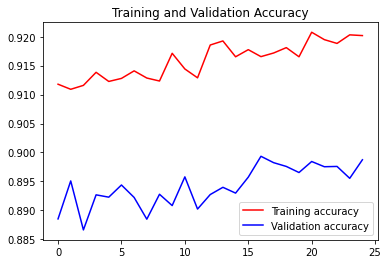

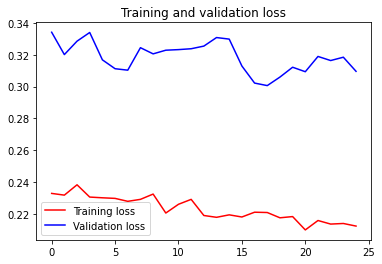

In [ ]:
his = history
accuracy = his.history['accuracy']
val_accuracy = his.history['val_accuracy']
loss = his.history['loss']
val_loss = his.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs,val_accuracy,'b',label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(testX, testY, verbose = 0)
print('Test Loss:' , score[0])
print('Test accuracy', score[1])

Test Loss: 0.2924085557460785
Test accuracy 0.9110999703407288
